# Modeling Prep
The purpose of this notebook is to work on prepping the pitch dataset for modeling in a machine learning pipeline.  This will pick up with the dataframe cleaned_pitch_df.pickle.

Importing various packages:

In [1]:
import pickle
from sqlalchemy import create_engine
import pandas as pd
from importlib import reload
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['retina']
%matplotlib inline

plt.rcParams['figure.figsize'] = (9, 6)
sns.set(context='notebook', style='whitegrid', font_scale=1.2)

Pickling in the data from data_cleaning.ipynb:

In [2]:
pwd

'/Users/patrickbovard/Documents/GitHub/metis_final_project'

In [3]:
with open('./Data/cleaned_pitch_df.pickle','rb') as read_file:
    pitch_df = pickle.load(read_file)

In [4]:
pitch_df.head()

,inning,batter_id,pitcher_id,top,ab_id,p_score,stand,p_throws,event,home_team,...,last_pitch_type,last_pitch_px,last_pitch_pz,last_pitch_speed,pitcher_full_name,pitcher_run_diff,hitter_full_name,Date_Time_Date,Season,Pitch_Family
0,1.0,572761,452657,1.0,2.015000e+09,0.0,L,L,Groundout,chn,...,None,NaN,NaN,NaN,Jon Lester,0.0,Matt Carpenter,2015-04-05,2015,
1,1.0,572761,452657,1.0,2.015000e+09,0.0,L,L,Groundout,chn,...,FF,0.416,2.963,92.9,Jon Lester,0.0,Matt Carpenter,2015-04-05,2015,
2,1.0,572761,452657,1.0,2.015000e+09,0.0,L,L,Groundout,chn,...,FF,-0.191,2.347,92.8,Jon Lester,0.0,Matt Carpenter,2015-04-05,2015,
3,1.0,572761,452657,1.0,2.015000e+09,0.0,L,L,Groundout,chn,...,FF,-0.518,3.284,94.1,Jon Lester,0.0,Matt Carpenter,2015-04-05,2015,
4,1.0,572761,452657,1.0,2.015000e+09,0.0,L,L,Groundout,chn,...,FF,-0.641,1.221,91.0,Jon Lester,0.0,Matt Carpenter,2015-04-05,2015,


In [5]:
pitch_df.columns

Index(['inning', 'batter_id', 'pitcher_id', 'top', 'ab_id', 'p_score', 'stand',
       'p_throws', 'event', 'home_team', 'away_team', 'b_score', 'on_1b',
       'on_2b', 'on_3b', 'px', 'pz', 'zone', 'pitch_type', 'start_speed',
       'type', 'b_count', 's_count', 'outs', 'pitch_num', 'last_pitch_type',
       'last_pitch_px', 'last_pitch_pz', 'last_pitch_speed',
       'pitcher_full_name', 'pitcher_run_diff', 'hitter_full_name',
       'Date_Time_Date', 'Season', 'Pitch_Family'],
      dtype='object')

Based on the pitch_df dataset, I plan on including the following columns as features: 
- inning, top, stand, p_throws, on_1b, on_2b, on_3b, b_count, s_count, outs, pitch_num, last_pitch_type, last_pitch_px, last_pitch_pz, last_pitch_speed, pitcher_run_diff (i.e. winning or losing)  

Of these, top, on_1b, on_2b, on3b are one hot encoded already w/ a 1 or 0.

Things that will need to be predicted are pitch type and then px/pz, in order to get type and then location.  Type will be predicted first, with location coming second.

For hitters, I am planning on clustering hitter types together, to reduce dimensionality from the full scope of hitters, to try to see how the pitcher would approach batters of a certain type.  This will be done with outside data.

For pitchers, I'll need to determine the pitcher's "arsenal", to see what pitches they will throw.  To prepare this, I'll find what percent of the time the pitcher throws each type of pitch.  

One last consideration will be how to divide the train/validation and test sets.  **TALK TO INSTRUCTOR**

## Pitch Arsenal Work

For the pitchers, I need to compile an "arsenal" for each pitcher.  To do this, I'll need to find what pitches each pitcher throws, and how often they do by rate.

In [6]:
pitch_df.pitcher_full_name.value_counts()

Max Scherzer        16240
Justin Verlander    16060
Jon Lester          15597
Rick Porcello       15556
Trevor Bauer        15531
                    ...  
Jose Rondon             4
Phillip Ervin           3
Alexi Amarista          3
Anthony Rizzo           2
Chris Denorfia          2
Name: pitcher_full_name, Length: 1451, dtype: int64

Overall, there are ~1451 pitchers to consider, but some (i.e. Anthony Rizzo and Jose Rondon) are position players and not pitchers, who likely had to pitch when their team was winning or losing by a ton.  **Will have to set a minimum pitch threshold when evaluating pitchers**.

Here, constructing the pitch arsenal dataframe, using similar code from *initial_sql_queries.ipynb* that I have moved into pitch_dataframe_functions.py:

In [7]:
from pitch_dataframe_functions import pitch_arsenal_generator, pitch_rate_generator

In [8]:
rate_df = pitch_rate_generator(pitch_df)

In [9]:
rate_df.head()

,Pitcher_Name,Pitch_Type,Pitch_Type_Count,Total_Pitch_Count,Pitch_Type_Rate
0,A.J. Achter,CH,281,790,0.355696
1,A.J. Achter,FC,57,790,0.0721519
2,A.J. Achter,FF,261,790,0.33038
3,A.J. Achter,FT,99,790,0.125316
4,A.J. Achter,SL,92,790,0.116456


For purposes of declaring in or out of a pitcher's given arsenal, I'll set a default at 5%, although this could be something a player or team could adjust using this tool.  In my mind, 5% means you'd see it 5 times if the pitcher were to throw 100 ptiches in a game, which would be less than 20% of the atbats.  

This is built using the pitch_arsenal_generator function in pitch_dataframe_functions.py file:

In [10]:
arsenal_df = pitch_arsenal_generator(pitch_df, threshold=0.05)

In [11]:
arsenal_df.head()

,Pitcher_Name,Pitch_Arsenal
0,Yu Darvish,"{'CU': 0.056808484700719246, 'FC': 0.210167012..."
1,Jeremy Hellickson,"{'CH': 0.26159369701805124, 'CU': 0.0947441906..."
2,Odrisamer Despaigne,"{'CH': 0.10091543156059285, 'CU': 0.0802092414..."
3,Hector Rondon,"{'FF': 0.4710640945861854, 'FT': 0.14021987139..."
4,Jeff Samardzija,"{'FC': 0.13562693384411376, 'FF': 0.2956387210..."


Building on these two previous functions, I'll be bringing in a dataframe of pitcher names, rates, and number of pitches in their arsenal:

In [12]:
from pitch_dataframe_functions import pitcher_pitch_rate_gen

In [13]:
new_df = pitcher_pitch_rate_gen(pitch_df, threshold=0.05)

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [14]:
new_df.head()

,Pitcher_Name,FF,CH,SL,CU,FT,FC,SI,FS,KC,EP,KN,FO,SC,Pitches_In_Arsenal
0,Yu Darvish,0.332805,0.000000,0.201512,0.056808,0.158844,0.210167,0.000000,0.000000,0.000000,0,0.0,0.0,0,5
1,Jeremy Hellickson,0.342475,0.261594,0.000000,0.094744,0.111599,0.059539,0.000000,0.000000,0.073601,0,0.0,0.0,0,6
2,Odrisamer Despaigne,0.298387,0.100915,0.063208,0.080209,0.000000,0.154098,0.267001,0.000000,0.000000,0,0.0,0.0,0,6
3,Hector Rondon,0.471064,0.000000,0.349513,0.000000,0.140220,0.000000,0.000000,0.000000,0.000000,0,0.0,0.0,0,3
4,Jeff Samardzija,0.295639,0.000000,0.192648,0.000000,0.217548,0.135627,0.000000,0.081479,0.000000,0,0.0,0.0,0,5


I would now have the ability to merge this dataframe with the rate of each pitch onto the full dataset, which would be extremely useful for machine learning applications.

### Merging Pitch Frequency onto the Full Set:

In [16]:
combined_df = pitch_df.merge(new_df, how='left', left_on='pitcher_full_name', right_on='Pitcher_Name')

In [17]:
combined_df.head()

,inning,batter_id,pitcher_id,top,ab_id,p_score,stand,p_throws,event,home_team,...,FT,FC,SI,FS,KC,EP,KN,FO,SC,Pitches_In_Arsenal
0,1.0,572761,452657,1.0,2.015000e+09,0.0,L,L,Groundout,chn,...,0.0,0.25896,0.101558,0.0,0.0,0,0.0,0.0,0,5
1,1.0,572761,452657,1.0,2.015000e+09,0.0,L,L,Groundout,chn,...,0.0,0.25896,0.101558,0.0,0.0,0,0.0,0.0,0,5
2,1.0,572761,452657,1.0,2.015000e+09,0.0,L,L,Groundout,chn,...,0.0,0.25896,0.101558,0.0,0.0,0,0.0,0.0,0,5
3,1.0,572761,452657,1.0,2.015000e+09,0.0,L,L,Groundout,chn,...,0.0,0.25896,0.101558,0.0,0.0,0,0.0,0.0,0,5
4,1.0,572761,452657,1.0,2.015000e+09,0.0,L,L,Groundout,chn,...,0.0,0.25896,0.101558,0.0,0.0,0,0.0,0.0,0,5


Dropping the Pitch_Family and Pitcher_Name columns, since those are not needed right now:

In [21]:
combined_df.drop(columns=['Pitch_Family', 'Pitcher_Name'], inplace=True)

### Pitch Arsenal EDA

Now that I have the number of pitchers in the arsenal, doing a quick visualization to see how many players have how many pitches in their arsenal.

In [25]:
arsenal_counts = list(combined_df.Pitches_In_Arsenal.value_counts())

In [26]:
arsenal_values = list(combined_df.Pitches_In_Arsenal.value_counts().index)

Plotting out the results:

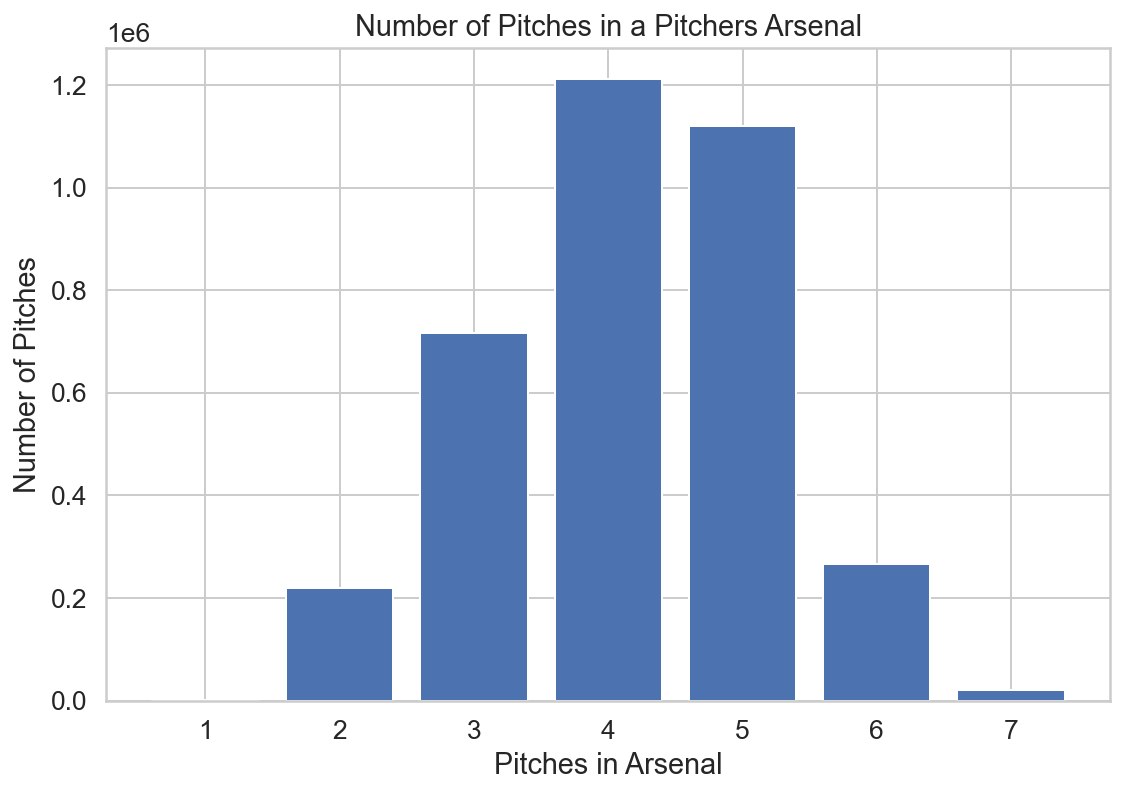

In [28]:
plt.bar(arsenal_values, arsenal_counts)
plt.title('Number of Pitches in a Pitchers Arsenal')
plt.xlabel('Pitches in Arsenal')
plt.ylabel('Number of Pitches')
plt.show();

It is centered around 4, which makes sense.  Logically too, the upper bounds make sense since no one would throw only 1 pitch type, and throwing over 7 would be insane.

In [30]:
combined_df[combined_df.Pitches_In_Arsenal == 7].pitcher_full_name.value_counts()

Trevor Bauer    15531
Mat Latos        3239
Nick Kingham     2336
Name: pitcher_full_name, dtype: int64

Trevor Bauer is notorious for throwing a ton of pitches, so it's not a surprise to see him on this list.